# Analytic solution of a two- and three-levels system

In [1]:
%matplotlib inline

import numpy
from astropy import units as u
import matplotlib.pyplot as plt
from frigus.readers.dataset import DataLoader
from frigus.population import population_density_at_steady_state

## Two level system

The analtic analytic ratios of the the level poputlations at equilbrium is presented and compared to the
numerical solution obtained by [Frigus](https://github.com/mherkazandjian/frigus).

### Analytic solution


$$
\mathbf{A} = 
\begin{bmatrix}
    0      & 0 \\
    A_{10} & 0 \\
\end{bmatrix}
$$

$$
\mathbf{B J_\nu} = 
\begin{bmatrix}
    0      & \frac{g_1}{g_0} A_{10} \\
    A_{10} & 0 \\
\end{bmatrix}
=
\begin{bmatrix}
    0      & B_{01} \\
    B_{10} & 0 \\
\end{bmatrix}
$$

$$
\mathbf{K} = 
\begin{bmatrix}
    0      & \frac{g_1}{g_0} K_{10} e^{-\frac{|E_{10}|}{k_b T_{\rm kin}}}\\
    K_{10} & 0 \\
\end{bmatrix}
=
\begin{bmatrix}
    0      & K_{01} \\
    K_{10} & 0 \\
\end{bmatrix}
$$

$$
\mathbf{n} = 
\begin{bmatrix}
    n_0 \\
    n_1 \\
\end{bmatrix}
$$


$$
\frac{d\mathbf{n}}{dt} = \mathbf{M} \cdot \mathbf{n} = \left[\left( \mathbf{A + B J_\nu + K}n_c \right)^T - (\mathbf{e}^T \cdot \mathbf{O}) \circ \mathbf{I}\right] \cdot \mathbf{n} \\
=
\begin{bmatrix}
    -(B_{01} + K_{01} n_c)
    & A_{10} + B_{10} + K_{10} n_c \\
    B_{01} + K_{01} n_c
    & -(A_{10} + B_{10} + K_{10} n_c)  \\
\end{bmatrix}
\cdot
\begin{bmatrix}
    n_0\\
    n_1\\
\end{bmatrix}
$$


The rate equations are

\begin{eqnarray}
\frac{dn_0}{dt} &=& -(B_{01} + K_{01}n_c) n_0 + (A_{10} + B_{10} + K_{10} n_c)n_1 \\
\frac{dn_1}{dt} &=& (B_{01} + K_{01}n_c) n_0 - (A_{10} + B_{10} + K_{10} n_c) n_1
\end{eqnarray}


At equilibrium, the ratio $n_1/n_0$ is:

$$                                                                                                                    \frac{n_1}{n_0} = \frac{B_{01} + K_{01}n_c}{A_{10} + B_{10} + K_{10}n_c} = \frac{M_{10}}{M_{01}}                 $$

### Comparison to the numerical solution obtained with Frigus 

load the data for a two-level system (pre-included in Frigus)

In [2]:
from frigus.population import population_density_ratio_analytic_two_level_system
species_data = DataLoader().load('two_level_1')

show the energy level(s)

In [3]:
print(species_data.energy_levels.data)

 j   g  label  E 
               eV
--- --- ----- ---
0.0 1.0   0.0 0.2
1.0 2.0   1.0 0.7


Show the content of the K matrix (at 100K e.g.)

In [4]:
print(species_data.K_dex_matrix_interpolator(100.0))

[[0.  0. ]
 [1.3 0. ]] m3 / s


show the content of the A matrix

In [5]:
print(species_data.A_matrix)

[[0.  0. ]
 [2.1 0. ]] 1 / s


set the values of the temperatures at which the comparison 
between the analytic and numerical will be done

In [6]:
T_kin_range = numpy.logspace(1.0, 6.0, 50) * u.Kelvin

define the model parameters

In [7]:
# density of the collider species
n_c = 1e6 * u.meter ** -3

# radiation temperature
T_rad = 100.0 * u.Kelvin

compute the population densities ratios (analytic solution)

In [8]:
ratio_analytic_vs_T_kin = []
for T_kin in T_kin_range:
    pop_dens = population_density_ratio_analytic_two_level_system(
        species_data.energy_levels.data['g'],
        species_data.energy_levels.data['E'],
        species_data.K_dex_matrix_interpolator(T_kin)[1, 0],
        species_data.A_matrix[1, 0],
        n_c,
        T_kin,
        T_rad
    )
    ratio_analytic_vs_T_kin.append(pop_dens)

ratio_analytic_vs_T_kin = numpy.array(ratio_analytic_vs_T_kin).flatten()

compute the population densities ratios (numerical solution with Frigus)

In [9]:
ratio_numeric_vs_T_kin = []
for T_kin in T_kin_range:
    pop_dens_eq = population_density_at_steady_state(
        species_data,
        T_kin,
        T_rad,
        n_c)
    pop_dens_eq_ratio = pop_dens_eq[1] / pop_dens_eq[0]
    ratio_numeric_vs_T_kin.append(pop_dens_eq_ratio)

ratio_numeric_vs_T_kin = numpy.array(ratio_numeric_vs_T_kin).flatten()

/home/mher/progs/sw/miniconda/envs/frigus/lib/python3.6/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


plot the population density computed numerically and analytically and also
plot the relative difference between them

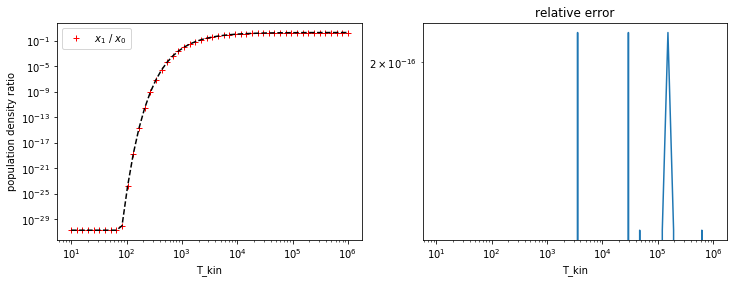

In [10]:
fig, (ax0, ax1) = plt.subplots(figsize=(12, 4), nrows=1, ncols=2)
ax0.loglog(T_kin_range, ratio_numeric_vs_T_kin, 'r+', label=r'$x_1$ / $x_0$')
ax0.loglog(T_kin_range, ratio_analytic_vs_T_kin, 'k--')
ax0.set_ylabel(r'population density ratio')
ax0.set_xlabel('T_kin')
ax0.legend()

relative_error = numpy.abs(
    1.0 - numpy.array(ratio_numeric_vs_T_kin) / numpy.array(
        ratio_analytic_vs_T_kin)
)
ax1.loglog(T_kin_range, relative_error)
ax1.set_xlabel('T_kin')
ax1.set_title('relative error')

plt.show()

### Three-level system

For a 3-levels system, the matrix formulation for the rate equations can be expressed as

$$
\mathbf{A} =
\begin{bmatrix}
    0      & 0      &  0  \\
    A_{10} & 0      &  0  \\
    A_{20} & A_{21} &  0  \\
\end{bmatrix}
$$                          

$$
\mathbf{B J_\nu} =
\begin{bmatrix}
    0      & \frac{g_1}{g_0} f_{10} A_{10} & \frac{g_2}{g_0} f_{20} A_{20} \\
    f_{10} A_{10} & 0                      & \frac{g_2}{g_1} f_{21} A_{21} \\
    f_{20} A_{20} & f_{21} A_{21}                 &   0                     \\
\end{bmatrix} =
\begin{bmatrix}
    0        & B_{01} &  B_{02} \\
    B_{10}   & 0      &  B_{12} \\
    B_{20}   & B_{21} &  0 \\
\end{bmatrix}
$$                                                                            

$$
\mathbf{K}=
\begin{bmatrix}
    0     & \frac{g_1}{g_0}K_{10}e^{-\frac{|E_{10}|}{k_b T_{kin}}} &  \frac{g_2}{g_0}K_{20}e^{-\frac{|E_{20}|}{k_b T_{kin}}} \\
    K_{10}& 0                                                      &  \frac{g_2}{g_1}K_{21}e^{-\frac{|E_{21}|}{k_b T_{kin}}} \\
    K_{20}& K_{20}                                                 &  0                                                      \\
\end{bmatrix} =
\begin{bmatrix}
    0      & K_{01} & K_{02}\\
    K_{10} & 0      & K_{12}\\
    K_{20} & K_{21} & 0     \\
\end{bmatrix};
\mathbf{n}=
\begin{bmatrix}
    n_0\\
    n_1\\
    n_2\\
\end{bmatrix}
$$


The rate equations are:
\begin{equation}
\begin{split}
\frac{dn_0}{dt} =& -(B_{01} + K_{01}n_c) n_0 -(B_{02} + K_{02}n_c) n_0 \\
                 & +(A_{10} + B_{10} + K_{10} n_c)n_1 + (A_{20} + B_{20} + K_{20} n_c)n_2\\
                =& -R_{01} n_0 - R_{02} n_0 \\
                 & + R_{10}n_1 + R_{20} n_2\\
\frac{dn_1}{dt} =& -(B_{12} + K_{12}n_c) n_1 - (A_{10} + B_{10} + K_{10} n_c)n_1  \\
                 & +(B_{01} + K_{01}n_c) n_0  + (A_{21} + B_{21} + K_{21} n_c)n_2\\
                =& -R_{12} n_1 - R_{10} n_1 \\
                 & + R_{01}n_0 + R_{21} n_2\\
\frac{dn_2}{dt} =& -(A_{21} + B_{21} + K_{21} n_c)n_2 -(A_{20} + B_{20} + K_{20} n_c)n_2\\
                 & +(B_{02} + K_{02}n_c) n_0  + (B_{12} + K_{12}n_c) n_1\\
                =& -R_{21} n_1 - R_{20} n_2 \\
                 & + R_{02}n_0 + R_{12} n_1\\
\end{split}
\end{equation}


where the terms in parenthesis have been grouped as $R_{ij}$ to facilitate the arithmetic
procedure of recovering the ratios of the level population at the equilibrium (as adopted
by [Draine 2010](https://press.princeton.edu/titles/9499.html)). Indeed, in such conditions, it can be easily found that
$n_2/n_1$ and $n_0/n_1$ are:
$$                                                                                                      
\frac{n_2}{n_1} = \frac{R_{10}R_{02}+R_{12}R_{01}+R_{12}R_{02}}{R_{21}R_{01}+R_{21}R_{02}+R_{01}R_{20}} 
$$
$$                                                                                                      
\frac{n_0}{n_1} = \frac{R_{10}R_{20}+R_{10}R_{21}+R_{12}R_{20}}{R_{01}R_{20}+R_{01}R_{21}+R_{21}R_{02}} 
$$


### Comparison to the numerical solution obtained with Frigus 

In [11]:
from frigus.population import population_density_ratio_analytic_three_level_system
species_data = DataLoader().load('three_level_1')

In [12]:
T_kin_range = numpy.logspace(1.0, 6.0, 50) * u.Kelvin
n_c = 1e6 * u.meter ** -3
T_rad = 100.0 * u.Kelvin

In [13]:
print(species_data.energy_levels.data)

 j   g  label  E 
               eV
--- --- ----- ---
0.0 1.0   0.0 0.2
1.0 2.0   1.0 0.7
2.0 5.0   2.0 1.3


In [14]:
print(species_data.A_matrix)

[[0.  0.  0. ]
 [2.1 0.  0. ]
 [3.2 1.4 0. ]] 1 / s


In [15]:
print(species_data.K_dex_matrix_interpolator(100.0))

[[0.  0.  0. ]
 [1.3 0.  0. ]
 [0.6 0.9 0. ]] m3 / s


In [16]:
ratio_analytic_vs_T_kin = []
for T_kin in T_kin_range:
    pop_dens_eq_ratio_analytic = population_density_ratio_analytic_three_level_system(
        species_data.energy_levels.data['g'],
        species_data.energy_levels.data['E'],
        species_data.K_dex_matrix_interpolator(T_kin)[1, 0],
        species_data.K_dex_matrix_interpolator(T_kin)[2, 0],
        species_data.K_dex_matrix_interpolator(T_kin)[2, 1],
        species_data.A_matrix[1, 0],
        species_data.A_matrix[2, 0],
        species_data.A_matrix[2, 1],
        n_c,
        T_kin,
        T_rad
    )

    ratio_analytic_vs_T_kin.append(numpy.array(pop_dens_eq_ratio_analytic))

ratio_analytic_vs_T_kin = numpy.array(ratio_analytic_vs_T_kin)

In [17]:
ratio_numeric_vs_T_kin = []

for T_kin in T_kin_range:

    pop_dens_eq_numeric = population_density_at_steady_state(
        species_data,
        T_kin,
        T_rad,
        n_c)

    pop_dens_eq_ratio_numeric = numpy.array(
        [
            pop_dens_eq_numeric[1] / pop_dens_eq_numeric[0],
            pop_dens_eq_numeric[2] / pop_dens_eq_numeric[0]
        ]
    ).flatten()
    ratio_numeric_vs_T_kin.append(pop_dens_eq_ratio_numeric)

ratio_numeric_vs_T_kin = numpy.array(ratio_numeric_vs_T_kin)

/home/mher/progs/sw/miniconda/envs/frigus/lib/python3.6/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


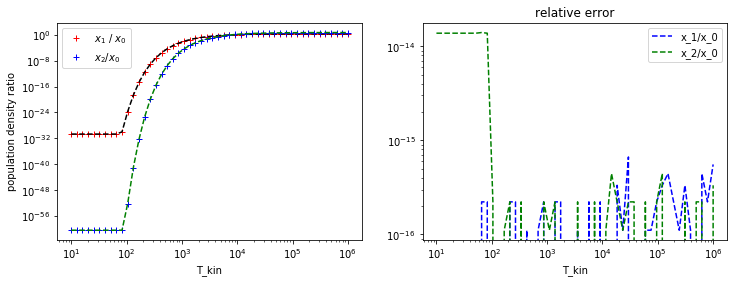

In [18]:
fig, (ax0, ax1) = plt.subplots(figsize=(12, 4), nrows=1, ncols=2)
ax0.loglog(T_kin_range, ratio_numeric_vs_T_kin[:, 0], 'r+', label=r'$x_1$ / $x_0$')
ax0.loglog(T_kin_range, ratio_analytic_vs_T_kin[:, 0], 'k--')

ax0.loglog(T_kin_range, ratio_numeric_vs_T_kin[:, 1], 'b+', label=r'$x_2$/$x_0$')
ax0.loglog(T_kin_range, ratio_analytic_vs_T_kin[:, 1], 'g--')
ax0.set_xlabel('T_kin')
ax0.set_ylabel(r'population density ratio')
ax0.legend()


relative_error = []
relative_error.append(
    numpy.abs(
        1.0 - numpy.array(ratio_numeric_vs_T_kin[:, 0]) / numpy.array(ratio_analytic_vs_T_kin[:, 0])
    )
)
relative_error.append(
    numpy.abs(
        1.0 - numpy.array(ratio_numeric_vs_T_kin[:, 1]) / numpy.array(ratio_analytic_vs_T_kin[:, 1])
    )
)
relative_error = numpy.array(relative_error)


ax1.loglog(T_kin_range, relative_error[0, :], 'b--', label='x_1/x_0')
ax1.loglog(T_kin_range, relative_error[1, :], 'g--', label='x_2/x_0')
ax1.set_xlabel('T_kin')
ax1.set_title('relative error')
ax1.legend()